### This code is to compare my python code with the tmm package
I have two python functions to compute the optical properties of a stack in admittance, stack and stack_v2.  stack_v2 is an attempt to vectorize the computation over an array of wavelengths.  stack only computes the properties of the stack for one wavelength.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import tes_optical_stack
import tes_optical_stack.admittance as admittance

In [4]:
stack_description = ['air',
                     'SiO2_Metricon',
                     'air',
                    ]
t = [np.inf, 200, np.inf]
t = np.array(t)

### when looking at results from stack_v2... if it is a matrix it is likely each row is the result for a particular wavelength

For the key 'RAT' in the result dictionary, it contains the results of the calculation...
the first column is reflected, the last column is transimtted, middle columns are absorption by layer

In [5]:
r = admittance.stack_v2(stack_description, t, np.array([1000, 1550]))
r['vac_lambdas'], r['RAT'], 

(array([1000, 1550]),
 array([[0.1225447 , 0.        , 0.8774553 ],
        [0.11079229, 0.        , 0.88920771]]))

# check stack_v2 against stack by individual wavelength

In [6]:
admittance.stack(r['stack_nk'][0], [np.inf, 200, np.inf], [1000])

{'R': array([0.1225447]),
 'T': array([0.8774553]),
 'poynting': array([0.8774553, 0.8774553])}

In [7]:
admittance.stack(r['stack_nk'][1], [np.inf, 200, np.inf], [1550])

{'R': array([0.11079229]),
 'T': array([0.88920771]),
 'poynting': array([0.88920771, 0.88920771])}

## Check using fixed index of refraction 1.45... not material stuff
Have to add a new fake material for stack_v2 to use.  It will have a constant n=1.45

In [8]:
admittance.stack(np.array([1, 1.45, 1]), [np.inf, 200,  np.inf], [1550])

{'R': array([0.10961162]),
 'T': array([0.89038838]),
 'poynting': array([0.89038838, 0.89038838])}

In [9]:
n_glass = admittance.nk_code.constant_n(1.45)
admittance.nk['glass'] = n_glass
admittance.nk['lossy_glass'] = admittance.nk_code.constant_n(1.45-0.1j)

stack_description = ['air',
                     'glass',
                     'air',
                    ]
t = [np.inf, 200, np.inf]
t = np.array(t)

r = admittance.stack_v2(stack_description, t, np.array([1550]))
r['vac_lambdas'], r['RAT'], 

(array([1550]), array([[0.10961162, 0.        , 0.89038838]]))

## Compare two layers and with a lossy material
sweep thickness

In [10]:
R = []
for t in np.arange(1550):
    r = admittance.stack(np.array([1, 1.45, 1.45-0.1j, 1]), [np.inf, t, t,  np.inf], [1550])
    R.append(r['R'])

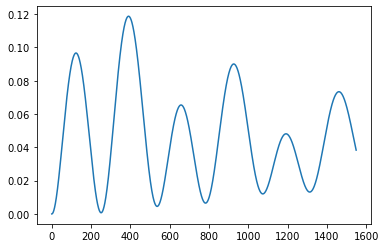

In [11]:
import matplotlib.pyplot as plt
plt.plot(R)

#  Must have package tmm installed for code below
https://pypi.org/project/tmm/

In [12]:
import tmm

In [13]:
import numpy as np
result = []
for t in np.arange(1550):
    d_list = [np.inf, t, t, np.inf] #in nm
    n_list = [1, 1.45, 1.45+0.1j, 1]
    th_0=0
    lam_vac=1550
    pol='p'
    coh_tmm_data = tmm.coh_tmm(pol,n_list,d_list,np.array([th_0]),np.array([lam_vac]))
    result.append(coh_tmm_data['R'])

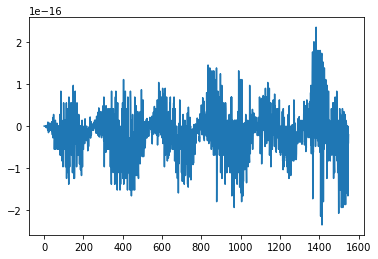

In [14]:
# subtract results from tmm with results from stack... difference is numerical precision
plt.plot(np.array(result)-np.array(R).ravel())

In [15]:
n_glass = admittance.nk_code.constant_n(1.45)
admittance.nk['glass'] = n_glass
admittance.nk['lossy_glass'] = admittance.nk_code.constant_n(1.45-0.1j)

stack_description = ['air',
                     'glass',
                     'lossy_glass',
                     'air',
                    ]
RR = []
for tt in range(1550):
    t = [np.inf, tt, tt, np.inf]
    t = np.array(t)

    r = admittance.stack_v2(stack_description, t, np.array([1000,1550]))
    RR.append(r['RAT'][1,0])
RR = np.array(RR)

In [16]:
r['RAT'][1,0], RR

(0.03834197361998003,
 array([3.08148791e-33, 2.00919600e-05, 8.01727440e-05, ...,
        3.94453570e-02, 3.88919616e-02, 3.83419736e-02]))

In [17]:
%timeit r=admittance.stack_v2(stack_description, t, np.array([1000,1550]))

269 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
r=admittance.stack_v2(stack_description, t, np.array([1000,1200,1550]))
r

{'stack_nk': array([[1.  +0.j , 1.45+0.j , 1.45-0.1j, 1.  +0.j ],
        [1.  +0.j , 1.45+0.j , 1.45-0.1j, 1.  +0.j ],
        [1.  +0.j , 1.45+0.j , 1.45-0.1j, 1.  +0.j ]]),
 'vac_lambdas': array([1000, 1200, 1550]),
 'RAT': array([[0.02531225, 0.        , 0.83965151, 0.13503624],
        [0.06339556, 0.        , 0.75616653, 0.18043791],
        [0.03834197, 0.        , 0.69451746, 0.26714057]])}

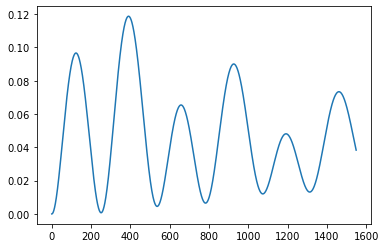

In [19]:
plt.plot(RR)

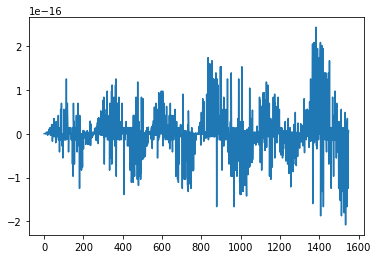

In [20]:
plt.plot(RR-np.array(R)[:,0])

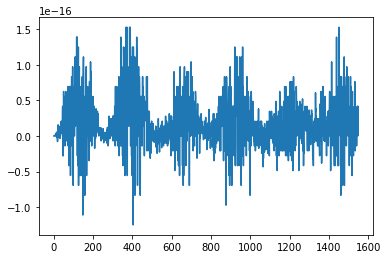

In [21]:
plt.plot(RR-result)

In [22]:
# check sum of R, A, and T ==1 for all wavelengths
r['RAT'].sum(axis=1)

array([1., 1., 1.])